In [26]:
'''
---------------------------------------------------------------------
LSTM Training
Version: V1.5
Modified: 18.10.2024
William Siegle
---------------------------------------------------------------------
notebook can be converted to python script using: 
(python -m) jupytext --to py FILENAME.ipynb
---------------------------------------------------------------------
'''

global IS_NOTEBOOK
IS_NOTEBOOK = False
try:    # if running in IPython
    shell = get_ipython().__class__.__name__ # type: ignore 
    %reset -f -s
    %matplotlib inline
    from IPython.display import display, HTML, Javascript
    from IPython.core.magic import register_cell_magic
    @register_cell_magic    # cells can be skipped by using '%%skip' in the first line
    def skip(line, cell): return
    from tqdm.notebook import tqdm # type: ignore
    IS_NOTEBOOK = True
except (NameError, ImportError):    # if running in script
    from tqdm import tqdm
    from tabulate import tabulate
    print(f"{'-'*60}\nRunning in script mode")

In [27]:
# IMPORTS ---------------------------------------------------------------------
import sys
import os
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from copy import deepcopy
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#from sklearn.metrics import mean_squared_error
#from torchinfo import summary
#import pickle
#import random
#from scipy.signal import savgol_filter

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import pack_sequence
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
torch.manual_seed(1);

___
LOCATE DEVICES & SYSTEM FOLDERS

In [28]:
# DEVICE SELECTION ---------------------------------------------------------------------
global DEVICE
print(f"{'-'*60}\nTorch version: ", torch.__version__)
print('Cuda available: ',torch.cuda.is_available())
if torch.cuda.is_available():
    DEVICE = torch.device(f"cuda") 
    #DEVICE = torch.device("cuda:1")   # or overwrite with explicit Core number
    print(f'Current Device: {torch.cuda.current_device()},  Total Count: {torch.cuda.device_count()}')
else:
    DEVICE = ("cpu")
print(f"   --> Using {DEVICE} device")

------------------------------------------------------------
Torch version:  2.3.1+cpu
Cuda available:  False
   --> Using cpu device


In [29]:
#  GET LOCATIONS OF REPOSITORY / DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT ------------------------------------------
global ROOT, DATA_PATH
if IS_NOTEBOOK:
    ROOT = Path('..', '..').resolve()
else:
    ROOT = Path('.').resolve()
sys.path.append(os.path.abspath(ROOT))

from data import get_data_path  # paths set in "data/__init__.py"
DATA_PATH = get_data_path()
print(f"{'-'*60}\nData located at: \t {DATA_PATH}")
print(f"Repository located at: \t {ROOT}")

------------------------------------------------------------
Data located at: 	 C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\DATA
Repository located at: 	 C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN


In [30]:
# FILE SOURCES ---------------------------------------------------------------
parquet_folder = Path(DATA_PATH, "processed") # Trip parquet files
save_model_folder = Path(ROOT, "src", "models", "pth")

___
DATA PREPROCESSING

In [31]:
# INPUT & TARGET SPECIFICATION ---------------------------------------------------
columns = ["signal_time", 
            "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "bs_roadincln_cval", "ambtemp_cval_pt", "hv_batpwr_cval_bms1", 
            "hv_batmomavldischrgen_cval_1"]

# Time and Target column taken out
input_columns = columns[1:-1]
target_column = columns[-1]

In [32]:
# PREPARE TRAIN & TEST SET ---------------------------------------------------
all_files = [Path(parquet_folder, f) for f in os.listdir(parquet_folder) if f.endswith(".parquet")]

# select Only first 100 Input-files in total
files = all_files[1000:2000]

# ---------------------------------------------------
# Train & Test Sets
# train_subset, test_subset = train_test_split(files, test_size=0.2, random_state=1)

train_subset, val_subset, test_subset = random_split(files, [0.8, 0.1, 0.1])

In [33]:
# FEATURE NORMALIZATION/SCALING -----------------------------------------------------------------
scaler = StandardScaler()   # Standardize features by removing the mean and scaling to unit variance
target_scaler = MinMaxScaler(feature_range=(0, 1))  #MinMaxScaler(feature_range=(0, 1))  # Transform features by scaling each feature to a given range

In [34]:
#%%skip
# PREPROCESSING STEPS ---------------------------------------------------
df = pd.read_parquet(files[8], columns=columns, engine='fastparquet')

# filling missing values ---------------
df.fillna(df.median(), inplace=True)  # Basic Median Filling 
#df.fillna(method='ffill', inplace=True)  # Forward fill
#df.fillna(method='bfill', inplace=True)  # Backward fill

if max(df['signal_time']).year < 2000:
    df['signal_time'] = pd.to_datetime(((df['signal_time']).astype('int64')) * (10**3))
else:   
    df['signal_time'] = pd.to_datetime(df['signal_time'])

              
# Resample time series data ------------
# Ensure the 'signal_time' column is set as the index and is of datetime type
#df['signal_time'] = pd.to_datetime(df['signal_time'])
df.set_index('signal_time', inplace=True)

# Resample the data to a lower frequency of 10 seconds and take the mean of each window
df_resampled = df.resample('10s').mean() # RESAMPLE AT 10 seconds intervals

# Reset the index if you want 'signal_time' to be a column again
#df_resampled.reset_index(inplace=True)
df_resampled.fillna(df.median(), inplace=True)

# assigning inputs and targets and reshaping ---------------
X = df_resampled[input_columns].values
y = df_resampled[target_column].values.reshape(-1, 1)     # reshape to match the shape of the input

X = scaler.fit_transform(X)
y = target_scaler.fit_transform(y).squeeze()

# Append to data
data, targets = [],[]
data.append(X)
targets.append(y)
df_resampled


,hirestotalvehdist_cval_icuc,vehspd_cval_cpc,altitude_cval_ippc,bs_roadincln_cval,ambtemp_cval_pt,hv_batpwr_cval_bms1,hv_batmomavldischrgen_cval_1
signal_time,,,,,,,
2022-04-29 20:31:05,89686.95500,0.000000,112.875,-0.600,16.50,-9.5975,317.800
2022-04-29 20:31:10,89686.95500,0.000000,112.875,-0.600,16.50,-9.6290,317.800
2022-04-29 20:31:15,89686.95500,0.000000,112.875,-0.600,16.50,-9.8100,317.800
2022-04-29 20:31:20,89686.95500,0.000000,112.875,-0.600,16.50,-10.0550,317.762
2022-04-29 20:31:25,89686.95500,0.000000,112.875,-0.600,16.50,-10.1390,317.750
...,...,...,...,...,...,...,...
2022-04-29 23:11:35,89862.09780,80.976562,105.235,-0.456,14.64,-98.5400,69.389
2022-04-29 23:11:40,89862.21020,80.975781,105.655,-0.400,14.66,-96.3460,69.246
2022-04-29 23:11:45,89862.32280,80.914687,105.765,-0.412,14.84,-84.6880,69.119


In [35]:
# DATASET DEFINITION -----------------------------------------------------------------------
class TripDataset(Dataset):
    def __init__(self, file_list, scaler, target_scaler):
        self.file_list = file_list
        self.scaler = scaler
        self.target_scaler = target_scaler
        self.data = []
        self.targets = []

        for file in self.file_list:
            # DATA PREPROCESSING -----------------------------------------------------------
            df = pd.read_parquet(file, columns=columns, engine='fastparquet')

            # filling missing values ---------------
            #df.fillna(df.median(), inplace=True)  # Basic Median Filling 
            df.fillna(method='ffill', inplace=True)  # Forward fill
            df.fillna(method='bfill', inplace=True)  # Backward fill
            
            # Resample time series data ------------
            # correct timestamp if necessary:
            if max(df['signal_time']).year < 2000:
                df['signal_time'] = pd.to_datetime(((df['signal_time']).astype('int64')) * (10**3))
            else:   
                df['signal_time'] = pd.to_datetime(df['signal_time'])

            df.set_index('signal_time', inplace=True)
            df_resampled = df.resample('10s').mean() # RESAMPLE AT 10 seconds intervals

            # Reset the index if you want 'signal_time' to be a column again
            #df_resampled.reset_index(inplace=True)
            # filling missing values ---------------
            df_resampled.fillna(df.median(), inplace=True)  # Basic Median Filling

            # assigning inputs and targets and reshaping ---------------
            X = df_resampled[input_columns].values
            y = df_resampled[target_column].values.reshape(-1, 1)     # reshape to match the shape of the input
            
            # Normalize inputs
            X = self.scaler.fit_transform(X)
            y = self.target_scaler.fit_transform(y).squeeze()
            
            # Append to data
            self.data.append(X)
            self.targets.append(y)

    def __len__(self):
        return sum(len(target) for target in self.targets)

    def __getitem__(self, index):
        # Find which file the index belongs to
        for i, target in enumerate(self.targets):
            if index < len(target):
                return (
                    torch.tensor(self.data[i][index], dtype=torch.float32).unsqueeze(0),  # Add time dimension
                    torch.tensor(target[index], dtype=torch.float32)
                )
            index -= len(target)
        raise IndexError("Index out of range")

In [36]:
# GENERATE DATALOADERS  ---------------------------------------------------------------
batch_size = 2048 # [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]

# TRAIN  ------------------------------------------------------------
train_dataset = TripDataset(train_subset, scaler, target_scaler)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# VAL ------------------------------------------------------------
val_dataset = TripDataset(val_subset, scaler, target_scaler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# TEST ------------------------------------------------------------
test_dataset = TripDataset(test_subset, scaler, target_scaler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the size of the datasets
print(f"{'-'*60}\nTrain size:  {len(train_dataset)}")
print(f'Val. size:   {len(val_dataset)}')
print(f'Test size:   {len(test_dataset)}')

------------------------------------------------------------
Train size:  3930614
Val. size:   512212
Test size:   541679


___
NETWORK ARCHITECTURE

In [37]:
# LSTM NETWORK -----------------------------------------------------------------------
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device = DEVICE): #, num_classes, seq_length):
        super(LSTM1, self).__init__()

        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers    # number of layers
        #self.num_classes = num_classes  # number of classes
        #self.seq_length = seq_length    # sequence length

        # LSTM CELL --------------------------------
        self.lstm = nn.LSTM(
            self.input_size,            # The number of expected features in the input x
            self.hidden_size,           # The number of features in the hidden state h
            self.num_layers,            # Number of recurrent layers for stacked LSTMs. Default: 1
            batch_first = True,         # If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Default: False
            bias = True,                # If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            dropout = 0.2,              # usually: [0.2 - 0.5] ,introduces a Dropout layer on the outputs of each LSTM layer except the last layer, (dropout probability). Default: 0
            bidirectional = False,      # If True, becomes a bidirectional LSTM. Default: False
            proj_size = 0,              # If > 0, will use LSTM with projections of corresponding size. Default: 0
            device = DEVICE,
            dtype = torch.float32
            ) 
        
        # --------------------------------
        #self.fc_1 =  nn.Linear(hidden_size, 128)  # fully connected 1
        #self.fc = nn.Linear(128, num_classes)     # fully connected last layer
        # --------------------------------
        self.relu = nn.ReLU()
        self.fc_test =  nn.Linear(hidden_size, 1)

    
    def forward(self, input, batch_size = None):
        '''        
        # initial hidden and internal states
        # --------------------------------
        h_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)
        c_0 = torch.zeros(self.num_layers, input.size(0) if batch_size is None else batch_size, self.hidden_size)  
        # --------------------------------
        out = self.relu(hn.view(-1, self.hidden_size)) # reshaping the data for Dense layer next
        out = self.fc_1(out) # first Dense
        out = self.relu(out) # relu
        out = self.fc(out) # Final Output
        '''

        # Propagate input through LSTM
        # --------------------------------
        # output, (hn, cn) = self.lstm(input, (h_0, c_0)) # lstm with input, hidden, and internal state
        # input shape:      (batch_size, seq_length, input_size)
        # output shape:     (batch_size, seq_length, hidden_size)
        # --------------------------------
        out, _ = self.lstm(input)


        # ouput layers
        # --------------------------------
        out = self.relu(out) # relu
        out = self.fc_test(out[:, -1, :])  
        #out = self.fc_test(out)

        return out

In [38]:
# MODEL CONFIGURATION -----------------------------------------------------------------------

# LAYERS --------------------------------
input_size = len(input_columns)     # expected features in the input x
hidden_size = 64                    # features in the hidden state h
num_layers = 2                      # recurrent layers for stacked LSTMs. Default: 1
num_classes = 1                     # output classes (=1 for regression)

# INSTANTIATE MODEL --------------------
model = LSTM1(input_size, hidden_size, num_layers).to(DEVICE)  #, num_classes, X_train_T_final.shape[1]
print(f"{'-'*60}\n",model)

------------------------------------------------------------
 LSTM1(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True, dropout=0.2)
  (relu): ReLU()
  (fc_test): Linear(in_features=64, out_features=1, bias=True)
)


___
TRAINING SETUP

In [39]:
# TRAINING CONFIGURATION -----------------------------------------------------------------------
global NUM_EPOCHS

# HYPERPARAMETERS -----------------------
NUM_EPOCHS = 5
learning_rate = 1e-3 # 0.001 lr

# OPTIMIZER -----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate,
    weight_decay = 1e-5      # weight decay coefficient (default: 1e-2)
    #betas = (0.9, 0.95),    # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    #eps = 1e-8,             # term added to the denominator to improve numerical stability (default: 1e-8)
)

# LOSS FUNCTION ---------------------------
def loss_fn(model_output, target):
    loss = F.mse_loss(model_output, target) # mean-squared error for regression
    return loss

# or define criterion function:
criterion = nn.MSELoss()
#criterion = nn.MSELoss(reduction='mean')

In [40]:
# print Model and Optimizer state_dicts
def print_state_dicts(model, optimizer=None):
    print(f"{'-'*60}\nModel state_dict:")
    for param_tensor in model.state_dict():
        print(f"{param_tensor}:\t {model.state_dict()[param_tensor].size()}")
        
    if optimizer:
        print("\nOptimizer state_dict:")
        for var_name in optimizer.state_dict():
            if var_name == 'param_groups':
                print(optimizer.state_dict()[var_name][0])

print_state_dicts(model, optimizer)
print(f"{'-'*60}\n{'-'*60}\n")

------------------------------------------------------------
Model state_dict:
lstm.weight_ih_l0:	 torch.Size([256, 6])
lstm.weight_hh_l0:	 torch.Size([256, 64])
lstm.bias_ih_l0:	 torch.Size([256])
lstm.bias_hh_l0:	 torch.Size([256])
lstm.weight_ih_l1:	 torch.Size([256, 64])
lstm.weight_hh_l1:	 torch.Size([256, 64])
lstm.bias_ih_l1:	 torch.Size([256])
lstm.bias_hh_l1:	 torch.Size([256])
fc_test.weight:	 torch.Size([1, 64])
fc_test.bias:	 torch.Size([1])

Optimizer state_dict:
{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 1e-05, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}
------------------------------------------------------------
------------------------------------------------------------



___

In [41]:
# Initialize a HTML table for performance tracking (if running in a notebook)
def initialize_table():
    table_html = """
    <table id="training_table" style="width:60%; border-collapse: collapse;">
        <thead style="position: sticky; top: 0; z-index: 1;">
            <tr>
                <th style="font-weight:bold; width:15%; text-align:left; padding: 10px; background-color: #404040;">Epoch</th>
                <th style="font-weight:bold; width:25%; text-align:left; padding: 10px; background-color: #404040;">Iteration</th>
                <th style="font-weight:bold; width:30%; text-align:left; padding: 10px; background-color: #404040;">Batch Loss</th>
                <th style="font-weight:bold; width:30%; text-align:left; padding: 10px; background-color: #404040;">Train Loss</th>
            </tr>
        </thead>
        <tbody>
        </tbody>
    </table>
    <script>
        function addRow(epoch, step, loss, running_loss) {
            var table = document.getElementById("training_table").getElementsByTagName('tbody')[0];
            var row = table.insertRow(-1);
            var cell1 = row.insertCell(0);
            var cell2 = row.insertCell(1);
            var cell3 = row.insertCell(2);
            var cell4 = row.insertCell(3);
            cell1.style.textAlign = "left";
            cell2.style.textAlign = "left";
            cell3.style.textAlign = "left";
            cell4.style.textAlign = "left";
            cell1.innerHTML = epoch;
            cell2.innerHTML = step;
            cell3.innerHTML = loss;
            cell4.innerHTML = running_loss;
            var scrollableDiv = document.getElementById("scrollable_table");
            scrollableDiv.scrollTop = scrollableDiv.scrollHeight;
        }
    </script>
    """

    return """<div id="scrollable_table" style="height: 300px; overflow-y: scroll;">""" + table_html + """</div>"""

# -----------------------
# Initialize a list for performance tracking (if running in script mode)
training_table = []

# Function to add a row to the performance table
def add_row(epoch, iteration, batch_loss, train_loss):
    training_table.append([epoch, iteration, batch_loss, train_loss])

# Function to print the performance table
header_printed = False
def print_row():
    global header_printed
    headers = ["Epoch", "Iteration", "Batch Loss", "Train Loss"]
    col_widths = [14, 14, 14, 14]  # Define fixed column widths

    def format_row(row):
        return [str(item).ljust(width) for item, width in zip(row, col_widths)]

    if not header_printed:
        formatted_headers = format_row(headers)
        tqdm.write(tabulate([training_table[-1]], headers=formatted_headers, tablefmt="plain", colalign=("left", "left", "left", "left")))
        header_printed = True
    else:
        formatted_row = format_row(training_table[-1])
        tqdm.write(tabulate([training_table[-1]], headers=format_row(["", "", "", ""]), tablefmt="plain", colalign=("left", "left", "left", "left")))

In [42]:
# TRAINING ROUTINE DEFINITION -----------------------------------------------------------------
def train_model(model, optimizer, loss_fn, train_loader, val_loader = None):

    def validate_model(model, val_loader, loss_fn):
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)  # Calculate average validation loss
        return val_loss

    # output info on training process
    print(f"Training Started.\tProcess ID: {os.getpid()} \n{'-'*60}\n"
        f"Model: {model.__class__.__name__}\t\tParameters on device: {next(model.parameters()).device}\n{'-'*60}\n"
        f"Train/Batch size:\t{len(train_loader.dataset)} / {train_loader.batch_size}\n"
        f"Optimizer:\t\t{optimizer.__class__.__name__}\nLR:\t\t\t{optimizer.param_groups[0]['lr']} \n{'-'*60}")
    
    if IS_NOTEBOOK: display(HTML(initialize_table()))

    # TRAINING LOOP:
    train_losses, val_losses = [], [] # collect loss
    start_time = time.perf_counter()
    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()   # set model to training mode
        running_loss = 0.0
        num_iterations = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
        header_printed = False
        
        with tqdm(enumerate(train_loader, 1), unit="batch", total=num_iterations, leave=False) as tepoch:
            for iter, (inputs, targets) in tepoch:
                tepoch.set_description(f"Epoch {epoch}/{NUM_EPOCHS}")

                # -------------------------------------------------------------
                # Move data to the GPU
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)  
                # zero gradients -> forward pass -> obtain loss function -> apply backpropagation -> update weights:
                optimizer.zero_grad()
                outputs = model(inputs) 
                loss = criterion(outputs.squeeze(), targets) 
                loss.backward() 
                # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0) # optional: Gradient Value Clipping
                optimizer.step()

                # -------------------------------------------------------------
                # Update the performance table
                if iter % (num_iterations//4) == 0 and iter != num_iterations//4*4:
                    add_row(f" ", f"{iter}",f"{loss.item():.6f}", " ")
                    if IS_NOTEBOOK:
                        display(Javascript(f"""addRow("", "{iter}", "{loss.item():.6f}", "");"""))
                    else:
                        print_row()
                elif iter == 1:
                    add_row(f"{epoch}/{NUM_EPOCHS}", f"{iter}/{num_iterations}",f"{loss.item():.6f}", " ")
                    if IS_NOTEBOOK:
                        display(Javascript(f"""addRow("<b>{epoch}/{NUM_EPOCHS}", "{iter}/{num_iterations}", "{loss.item():.6f}", "");"""))
                    else:
                        print_row()
                        
                # -------------------------------------------------------------
                # Update running loss and progress bar
                running_loss += loss.item() # acculumate loss for epoch
                tepoch.set_postfix(loss=loss.item()); tepoch.update(1)

        # Calculate average training loss for the epoch
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Update the performance table
        add_row(f" ", f"{iter}",f"{loss.item():.6f}", f"{avg_train_loss:6f}")
        if IS_NOTEBOOK:
            display(Javascript(f"""addRow("", "{iter}", "{loss.item():.6f}", "<b>{avg_train_loss:.6f}");"""))
        else:
            print_row()

        # VALIDATION
        if val_loader:
            val_loss = validate_model(model, val_loader, loss_fn)
            val_losses.append(val_loss)
            # Update the performance table
            add_row(f" ", f"Validation Loss:",f"{val_loss:.6f}", f"")
            if IS_NOTEBOOK:
                display(Javascript(f"""addRow("<b>Val", "Validation Loss:", "<b>{val_loss:.4f}", "");"""))
            else:
                print_row()

    print(f"{'-'*60}\nTraining Completed.\tExecution Time: ", f"{(time.perf_counter() - start_time):.2f}", f"s\n")
    return train_losses, val_losses, epoch, training_table

___
NETWORK TRAINING

In [43]:
# NETWORK TRAINING -----------------------------------------------------------------
train_losses, val_losses, epochs_completed, training_table = train_model(
    model = model, 
    optimizer = optimizer, 
    loss_fn = criterion, 
    train_loader = train_loader,
    val_loader = val_loader
    )

Training Started.	Process ID: 20872 
------------------------------------------------------------
Model: LSTM1		Parameters on device: cpu
------------------------------------------------------------
Train/Batch size:	3930614 / 2048
Optimizer:		Adam
LR:			0.001 
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/1920 [00:00<?, ?batch/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

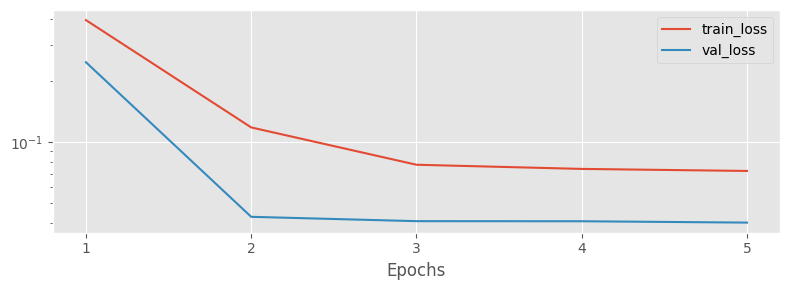

In [120]:
# get DataFrame of training metrics:
training_df = pd.DataFrame(training_table, columns=["Epoch", "Iteration", "Batch Loss", "Train Loss"])
# Extract the 'Train Loss' column and compare with the train_losses list
train_loss_column = training_df['Train Loss'].replace(['',' '], np.nan).dropna().astype(float).values
if any(abs(train_loss_column - train_losses) > 1e-3): print("Extracted and original Train Losses are not equal. Please check metrics table.")

# -------------------------------------
# plot training performance:
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(8,3))

# Set x-axis to integers starting from 1
ax1.set_xlabel('Epochs')
ax1.set_xticks(range(1, NUM_EPOCHS + 1))

plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='train_loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='val_loss')
plt.yscale('log')
fig.tight_layout(); plt.legend();


___
EVALUATION / POST-PROCESSING

In [121]:
# EVALUATION -----------------------------------------------------------------
model.eval() # set model to evaluation mode
test_loss = 0

with torch.no_grad():

    for iter, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)

        # Optional: Inverse-transform outputs and targets for evaluation
        # You can use `scaled_outputs` and `scaled_targets` for error metrics in the original scale if needed
        scaled_outputs = target_scaler.inverse_transform(outputs.detach().cpu().numpy().reshape(-1, 1))
        scaled_targets = target_scaler.inverse_transform(targets.detach().cpu().numpy().reshape(-1, 1))

        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss:  {test_loss:.4f}")
print(f"Iterations: {iter}/{math.floor(len(test_loader.dataset) / test_loader.batch_size)}")

Test Loss:  0.0834
Iterations: 6/6


In [122]:
# SAVE MODEL  -----------------------------------------------------------------

# create unique model name
timestamp = datetime.now().strftime("%y%m%d_%H%M%S")
model_name = f"{model.__class__.__name__}_{timestamp}"
model_destintion_path = Path(save_model_folder, model_name + ".pth")

# SAVE STATE_DICT FOR MODEL INFERENCE -----------------
torch.save(model.state_dict(), model_destintion_path)
print(f"Model saved to:\t {model_destintion_path}")
'''
# Later to restore:
model.load_state_dict(torch.load(model_destintion_path))
model.eval() # set model to evaluation mode for inference
'''

# OPTIONAL: SAVE COMPLETE MODEL DICT FOR RESUMING TRAINING LATER -----------------
'''
state = {
    'epoch': epochs_completed,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss_func': criterion, 
    'train_loader': train_loader, 
    'train_losses': train_losses
}
torch.save(state, model_destintion_path)
print(f"Complete Model dict saved to:\t {model_destintion_path}")

# Later to restore:
state = torch.load(model_destintion_path)
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])
''';

Model saved to:	 C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN\src\models\pth\LSTM1_241022_111023.pth


In [123]:
# keep best performing model:
#best_model_state = deepcopy(model.state_dict())

In [124]:
test_files

NameError: name 'test_files' is not defined

In [23]:
random.sample(test_files,1)

[WindowsPath('C:/Users/SIEGLEW/OneDrive - Daimler Truck/MA/Code/DATA/processed/v_id983V101_trip156_2.parquet')]

In [24]:
test_dataset = TripDataset(random.sample(test_files,1), scaler, target_scaler)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

model.eval()
y_pred = []
with torch.no_grad():

    for iter, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        y_pred.append(torch.mean(outputs).item())

y_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))


In [25]:
model.eval()
with torch.no_grad():
    # Randomly select a sequence from the test dataset
    seq = random.randint(0, len(test_loader.dataset.data) - 1)

    # Get the inputs and targets for the selected sequence
    test_inputs = torch.tensor(test_loader.dataset.data[seq], dtype=torch.float32).unsqueeze(0).to(DEVICE).contiguous()
    test_targets = torch.tensor(test_loader.dataset.targets[seq], dtype=torch.float32).to(DEVICE).contiguous()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Perform inference
    outputs = model(test_inputs)
    inference_loss = criterion(outputs, test_targets)
    print(f"Inference Loss:  {inference_loss.item():.4f}")

    # Inverse-transform the outputs and targets for evaluation
    y_pred = target_scaler.inverse_transform(outputs.detach().cpu().numpy().reshape(-1, 1))
    y_true = target_scaler.inverse_transform(test_targets.detach().cpu().numpy().reshape(-1, 1))

    # Print the first few predictions and true values for comparison
    print("Predicted values:", y_pred[:5].flatten())
    print("True values:", y_true[:5].flatten())

Inference Loss:  0.1356
Predicted values: [131.80869]
True values: [224.95 224.95 224.95 224.95 224.95]


c:\Users\SIEGLEW\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([22242])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [26]:
#%%skip
# PLOT RESULTS -----------------------------------------------------------------

# Reverse Transformation of the latest output and target
scaled_outputs = target_scaler.inverse_transform(outputs.detach().cpu().numpy().reshape(-1, 1))
scaled_targets = target_scaler.inverse_transform(targets.detach().cpu().numpy().reshape(-1, 1))

In [27]:
y_true = target_scaler.inverse_transform(np.array(test_loader.dataset.targets[0] ).reshape(-1, 1))
y_true.shape

(22242, 1)

ValueError: x and y must have same first dimension, but have shapes (2225,) and (1, 1)

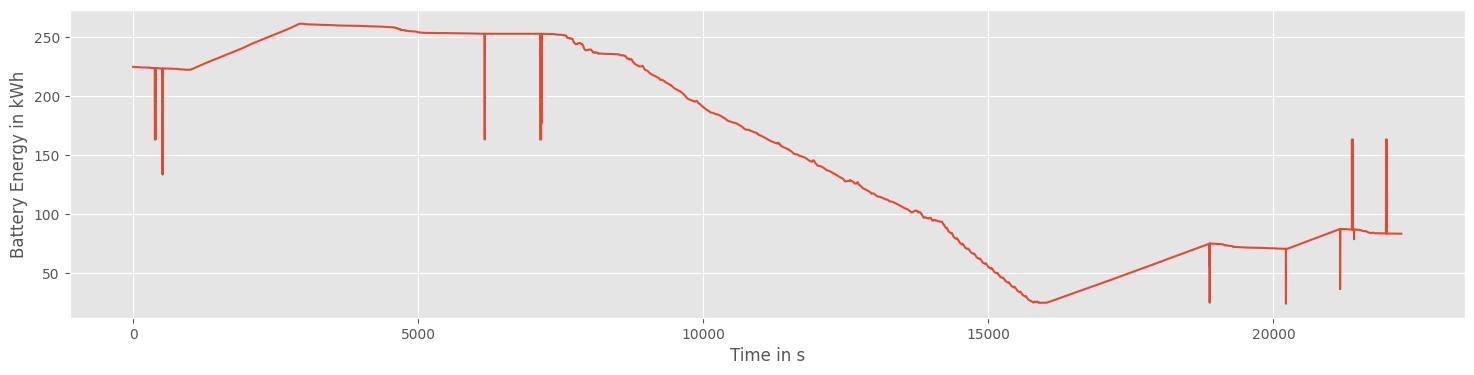

In [28]:

plt.figure(figsize=(18,4)) 

plt.xlabel('Time in s')
plt.ylabel('Battery Energy in kWh')

plt.plot(y_true, label='Actual Data') # actual plot
plt.plot(np.arange(0, len(y_true), 10), y_pred, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend();

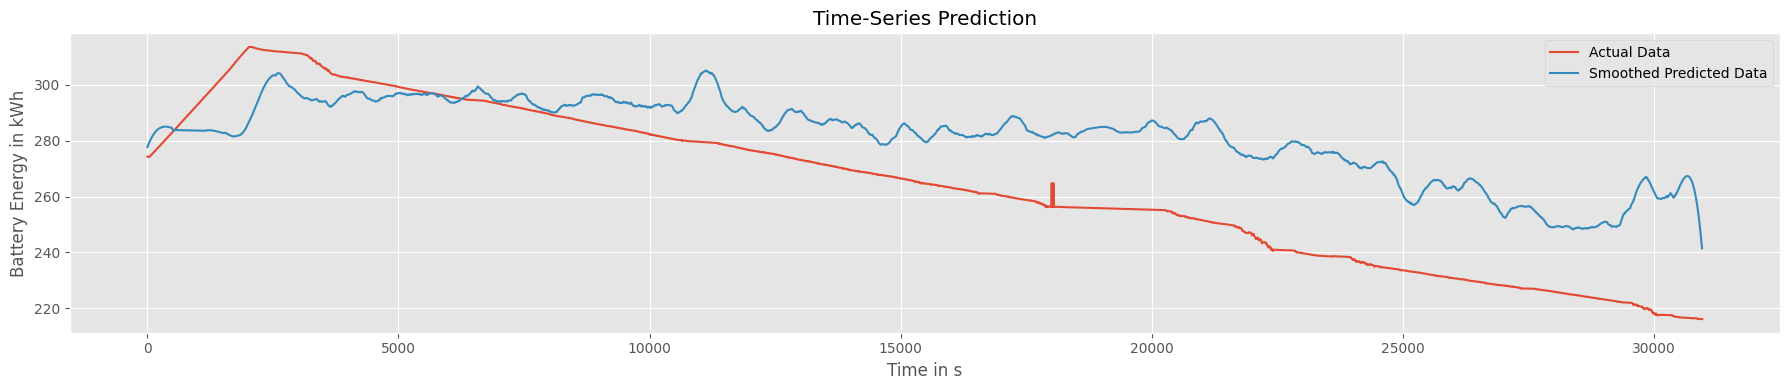

In [504]:
from scipy.signal import savgol_filter

plt.figure(figsize=(18,4)) 

# Original and Smoothed plot
plt.xlabel('Time in s')
plt.ylabel('Battery Energy in kWh')
plt.plot(y_true, label='Actual Data') # actual plot
#plt.plot(np.arange(0, len(y_true), 10), y_pred, label='Predicted Data') # predicted plot

# Smoothed predicted plot
smoothed_y_pred = savgol_filter(y_pred.flatten(), window_length=100, polyorder=3)
plt.plot(np.arange(0, len(y_true), 10), smoothed_y_pred, label='Smoothed Predicted Data')

plt.title('Time-Series Prediction')
plt.legend()
plt.tight_layout()
plt.show()
